In [16]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [17]:
with open("MyFitbitData/DanieladelRo/Physical_Activity/heart_rate-2021-08-31.json") as f:
    json_data = json.load(f)

In [18]:
print ("Dict keys 1 are : ")
dict_keys1 = [k for k in json_data[0]]
print(dict_keys1)

values1 = [json_data[0][k] for k in json_data[0]]
print ("Dict keys 2 are : ")
dict_keys2 = [k for k in values1[1]]
print(dict_keys2)

print ("Values are : ")
values2 = [values1[1][k] for k in values1[1]]
print(values2)

# And then we are interested in values2[0]

heart_rate = np.zeros(len(json_data))

for i in range(len(json_data)):
    values1 = [json_data[i][k] for k in json_data[i]]
    values2 = [values1[1][k] for k in values1[1]]
    heart_rate[i] = values2[0]

Dict keys 1 are : 
['dateTime', 'value']
Dict keys 2 are : 
['bpm', 'confidence']
Values are : 
[61, 3]


In [15]:
heart_rate

array([61., 60., 59., ..., 63., 63., 63.])

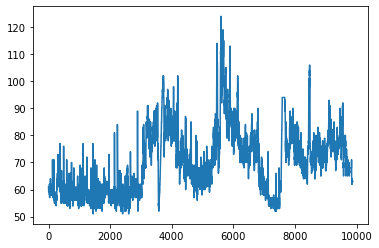

In [19]:
plt.plot(heart_rate)
plt.show()

In [ ]:
for i in json_data[0] :
    print(i, json_data[0][i])

In [ ]:
json_data